## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [3]:
import glob

import numpy as np
import scipy as sp
import scipy.io
from scipy import signal
from scipy.signal import butter, lfilter
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability.

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def butter_bandpass_filter(signal, fs, pass_band=(40/60.0, 240/60.0)):
  """
  Bandpass given numpy array singal between 40 Hz and 240 Hz by default
  Args:
    signal: numpy array. ppm/acc signal
    fs: int. Sampling frequency in Hz
    pass_band: tuple. filter band width set to between 40BPM(40/60 Hz) and 240BPM(40Hz) by default
    order: int. order of butter band pass
  Returns:
    filtered_signal: ndarray of bandpassed signal
  """
  numerator_vector, denominator_vector = sp.signal.butter(5, pass_band, btype='bandpass', fs=fs)
  return scipy.signal.filtfilt(numerator_vector, denominator_vector, signal)

def RunPulseRateAlgorithm(data_fl, ref_fl, fs = 125, window_length=8, window_shift=2, min_bandpass=(40/60.0), max_bandpass=(240/60.0)):
    """
    Returns the absolute error between the algorithm based bpm predictions from the inputed data file and the reference file
    alongside a list of corresponding confidence scores
    Args:
        data_fl: str filepath to DATA file
        ref_fl: str filepath to REF file 
    Return:
        errors: numpy array list of absolute difference error between the inputted reference file and predicted heart rate values
        confidence: numpy array list of the corresponding confidence scores for the predicted heart rate values 
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Bandpass filter the ppg data
    filtered_ppg = butter_bandpass_filter(ppg, fs)
    
    # filter the x,y,and z component of the accelerometer data 
    filtered_accx = butter_bandpass_filter(accx, fs)
    filtered_accy = butter_bandpass_filter(accy, fs)
    filtered_accz = butter_bandpass_filter(accz, fs)

    filtered_acc = np.sqrt(filtered_accx**2 + filtered_accy**2 + filtered_accz**2)

    ground_truth = scipy.io.loadmat(ref_fl)['BPM0'].reshape(-1)

    # use shifting window technique to calculate predictions, confidence and error 
    window_length = window_length * fs
    window_shift = window_shift * fs

    # bpm predictions and confidence estimates empty lists 
    bpm_predictions = []
    confidence_estimates = []

    #shifting window calculations of 8 filtered_ppg with 6 second overlaps
    for shift_start_index in range(0, len(ppg) - window_length + 1, window_shift):
        # extracting corresponding ppg and accelerometer data windows(8 seconds long each)
        ppg_window = filtered_ppg[shift_start_index:shift_start_index+window_length]
        acc_window = filtered_acc[shift_start_index:shift_start_index+window_length]
        accx_window = filtered_accx[shift_start_index:shift_start_index+window_length]
        accy_window = filtered_accy[shift_start_index:shift_start_index+window_length]
        accz_window = filtered_accz[shift_start_index:shift_start_index+window_length]
        # fourier transform the window
        ppg_window_length = len(ppg_window) 
        acc_window_length = len(acc_window) 

        # extracting magnitude of pgg and accelerometer data frequencies and fourier transform of the window 
        ppg_frequencies, ppg_fast_fourier_transform = np.abs(np.fft.rfftfreq(ppg_window_length, 1/fs)), np.abs(np.fft.rfft(ppg_window, ppg_window_length))

        acc_frequencies, acc_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(acc_window, acc_window_length))
        accx_frequencies, accx_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accx_window, acc_window_length))
        accy_frequencies, accy_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accy_window, acc_window_length))
        accz_frequencies, accz_fast_fourier_transform = np.abs(np.fft.rfftfreq(acc_window_length, 1/fs)), np.abs(np.fft.rfft(accz_window, acc_window_length))

        
        # clipping all unwanted frequencies below and above the min and max bandpasses for the ppg data
        ppg_fast_fourier_transform[(ppg_frequencies <= min_bandpass) | (ppg_frequencies >= max_bandpass)] = 0.0
        # clipping all unwanted frequencies below and above the min and max bandpasses for the acc data
        acc_fast_fourier_transform[(acc_frequencies <= min_bandpass) | (acc_frequencies >= max_bandpass)] = 0.0
        # clipping all unwanted frequencies below and above the min and max bandpasses for the acc x,y, and z components individually
        accx_fast_fourier_transform[(accx_frequencies <= min_bandpass) | (accx_frequencies >= max_bandpass)] = 0.0
        accy_fast_fourier_transform[(accy_frequencies <= min_bandpass) | (accy_frequencies >= max_bandpass)] = 0.0
        accz_fast_fourier_transform[(accz_frequencies <= min_bandpass) | (accz_frequencies >= max_bandpass)] = 0.0

        #pick most prominent ffq frequency 
        ppg_frequency = ppg_frequencies[np.argmax(ppg_fast_fourier_transform, axis=0)]
        acc_frequency = acc_frequencies[np.argmax(acc_fast_fourier_transform, axis=0)]

        # confidence calculation from fourier transform inputs
        ppg_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, ppg_frequency)

        # setting the frequency to return as the ppg frequency right now but can change based on relative ppg/acc frequencies
        frequency_to_return = ppg_frequency
        confidence_to_return = ppg_confidence
        # if the accelerometer frequency is too close to the ppg frequency then first check for if the 
        # second biggest frequency is a viable option as suggested by udacity project overview before iteration
                        
        if (acc_frequency - ppg_frequency == 0.0):
            next_best_frequency = ppg_frequencies[np.argsort(ppg_fast_fourier_transform, axis=0)[-2]]  
            corresponding_accelerometer_frequency = acc_frequencies[np.argsort(acc_fast_fourier_transform, axis=0)[-2]]
            next_best_frequency_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, next_best_frequency)
            frequency_to_return, confidence_to_return = next_best_frequency, next_best_frequency_confidence
        else:
            for i in range(0, len(ppg_fast_fourier_transform)):
                next_best_frequency = ppg_frequencies[np.argsort(ppg_fast_fourier_transform, axis=0)[-(i+1)]]
                corresponding_accelerometer_frequency = acc_frequencies[np.argsort(acc_fast_fourier_transform, axis=0)[-(i+1)]]
                next_best_frequency_confidence = calc_confidence(ppg_frequencies, ppg_fast_fourier_transform, next_best_frequency)

                # replacing the return frequency and confidence to that of the second biggest frequency if its confidence 
                # is higher and isn't affected by arm swing cadence frequency, repeating iteration process through all frequencies
                if ((next_best_frequency_confidence - confidence_to_return >= 0.2) & (np.abs(corresponding_accelerometer_frequency - next_best_frequency) > 0.15)):
                    frequency_to_return, confidence_to_return = next_best_frequency, next_best_frequency_confidence



        bpm_predictions.append(frequency_to_return * 60) # multiplying by 60 because ground truth values are in bpm
        confidence_estimates.append(confidence_to_return)

    # final return is list of absolute value difference errors from the ground truth 
    errors = np.array(np.abs(np.subtract(bpm_predictions, ground_truth)))
    confidence_estimates = np.array(confidence_estimates)
    
    return errors, confidence_estimates

def calc_confidence(frequencies, fft, frequency, window=40/60.0):
  """
  Returns confidence score of the inputted frequency based on the corresponding fourier transform input
  Args:
    frequencies: numpy array that is the list of frequency bins
    fft: float that is FFT of normalized signal
    frequency: float of frequency for confidence calculation
  Returns:
    confidence: float value that is outcome of frequency specific summation over total fourier transform summation
  """
  confidence = np.sum(fft[(frequencies >= frequency - window) & (frequencies <= frequency + window)]) / np.sum(fft)
  return confidence



-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm.
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

**Project References & Credits**
I got the idea for my main shifting window technique in part 1 in the RunPulseRateAlgorithm() function from the following githubs: https://github.com/sahikabetul/Motion-Compensated-Pulse-Rate-Estimation-by-Wearable-Device-Data/blob/main/pulse_rate_starter.ipynb, https://github.com/ElliotY-ML/Heart_Rate_Estimation_PPG_Acc, https://github.com/iDataist/Motion-Compensated-Pulse-Rate-Estimation/blob/master/part_1/pulse_rate.ipynb. My method of extracting the final frequency for a given window is a combination of accelerometer data and confidence score mindful approach. 

I decided to create a separate confidence calculation helper function from the following githubs and from the project rubric suggestions as it seemed to greatly increase code readability and that it was a simple function that was better written once:https://github.com/nathan-vo810/Motion-Compensated-Pulse-Rate-Estimation, https://github.com/sahikabetul/Motion-Compensated-Pulse-Rate-Estimation-by-Wearable-Device-Data/. 

Once again here are all my general project references:
https://github.com/nathan-vo810/Motion-Compensated-Pulse-Rate-Estimation
https://github.com/sahikabetul/Motion-Compensated-Pulse-Rate-Estimation-by-Wearable-Device-Data
https://github.com/iDataist/Motion-Compensated-Pulse-Rate-Estimation
https://github.com/ElliotY-ML/Heart_Rate_Estimation_PPG_Acc
https://github.com/rafaca5tro/Motion-Compensated_Pulse_Rate_Estimation/blob/master/pulse_rate_starter.ipynb
https://github.com/aaryapatel007/Motion-Compensated-Pulse-Rate-Estimation/blob/master/pulse_rate_estimation.ipynb

1. **Code Description**

**Required Imporrts** 
Glob - version 2.0.0
Numpy - version 1.12.1
Scipy - version 1.2.1

**Inputs**
data files: .mat files with ECG, PPG, and accelerometer measurements --> all the data files for training should start with 'DATA_' 

reference file: .mat file with the corresponding ground truth pulse rates calculated from the ECG measurements of the data file --> all the reference files for training should start with 'REF_'

**Output**
MAE of algorithm between inputted data and reference file

**How to run**
Make sure that you have downloaded the data file set and the corresponding reference file set in the local. 

Then make sure that in the **LoadTriokaDataset** the data_directory path variables are all set correspondingly to where your data is in your IDE/environment. Then call the Evaluate() function in a seperate code cell which will return the MAE of the algorithm for the given data and reference files.


2. **Data Description**

The dataset used to train this algorithm is from Z.Zhang, Z. Pi, and B.Liu's study ""TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise." 

The detail that their study used 12 male subjects ages 18-35 who were monitered through their wrist PPG device  as they ran on treadmills with changing speeds for 5 minutes.
The excercise was split into the following intervals: rest for 30 seconds, run for 4 minutes, and cooldown for 30 seconds.

All signals were sampled at 125 Hz. 

The datasets contain the sampled data as well as referenced ground truth herat values calculated from the ECG.

My algorithm predicts from the objective sampled values and then learns/trains from the ground truth reference values provided.

**Data shortcoming**: A shortcoming of the study may be the lack of diversity in regards to all subjects being male as well as uncertainity of the skin color of participants. Melanin concentration does affect PPG data collection and subject diversity is crucial for better estimation/generalization of models training from the sampled heart rate data. 



3. **Algorithm Description**

 
 **Physiological Aspect of Algorithm**

The RunPulseRateAlgorithm() is based on the physiology of the heart beat, best represented by Pan-Tompkins. When the heart contracts, blood fills the extremities and when the heart relaxes the blood once again leaves the extremities back to the heart. Corresponding, PPG/Photoplethysmography(PPG) sensors worn on a user's wrist estimate the pulse rate in fluctuation with relative levels of blood flow and readings(based on reflected light) are higher when the heart contracts and lower when the heart relaxes. The steady rythm of heart beat based on the sinus node and the corresponding depolarization/polarization processes it triggers in the atria and ventricles can be seen in ppg readings and thereafter used to determine pulse rate. During systole, capillaries fill with blood and during diastole the blood leave capillaries and they are respectively reflected by spikes and drops in PPG that we can take advantage of.

 **How the Algorithm works through code**
 
 Note that the top-level function called is the Evaluate() that will then trigger the following series of functions to run the algorithm: 

 a. The function **LoadTriokaDataset**() returns two lists: data_fls which is a list of all the files that start with 'DATA_' in the directory and ref_fls which is a list of all the files that start with 'REF_' in the directory.

 b. For each data and reference file with the returned data_fls and ref_fls file lists from the LoadTroikaDataSet function, the Evaluate function will then run the following RunPulseRateAlgorithm and calculate the error and confidence for each data batch. 

**Algorithm Logic**
 
 c. The **RunPulseRateAlgorithm**(data_fl, ref_fl) will accept the given data and reference file paths, load the data file via the the **LoadTroikaDataFile** function that will load the gven data path and return a  numpy array with the the corresponding PPG and 3-axis(x,y,z) accelerometer sensor measurements. RunPulseAlgortihm will then take the PPG and accelerometer sensor data and run them through following processing steps:
  i.Both the PGG and accelerometer signals are bandpassed through a 40 BPM to 240 BPM filter(0.66 Hz and 40 Hz respectively).
  ii. Predict heart rate from the pgg and accelerometer data signals via a shifting window technique:

    1. Define window length and shift constants from the args or their default values. Then the function will go onto to perform the following series of steps for each part/window of the signal.

    Note that by default each window is of 8 seconds with 6 second overlaps 
    
    2.Within the window, the largest magnitude/characteristic PGG data peak is found alongside its confidence calculation. Note that confidence of each pulse rate is determinated as the sum of intensity magnitudes within 10 BPM of the original frequency over the sum of intensity magnitudes across all frequencies(as seen in the confidence_calculator function).
    The algorithm then compares the highest magnitude peak with the second highest confidence score peak and sets the possible return frequency as the second highest peak if the confidence score is greater. 
  
    The algorithm then runs through all the frequencies after the largest magnitude frequency and compares the confidence score and similarity to the corresponding accelerometer spike frequency of each frequency. If the confidence score of a frequency is higher by atleast 0.2 and it does not overlap with arm swing cadence significantly, it is selected as the next best frequency. This process repeats for each frequency in a magnitude-wise descending order. 

    3. Once pulse rate frequency for the window is determinated it is converted from beats per second to beats per minute through a simple multiplication factor of 60. 

    4. The final bpm prediction and confidence calculation of the window are appended to a overall list of all bpm predictions and confidences scores as the final return of the predict_heart_rate function. 

  iii. Once the heart rate bpm predictions and confidence calculations are extracted from the signal, the RunPulseRateAlgorithm() then then calculates the absolute error between the predicted bpm heart rates and the ground truth bpm heart rates extracted from the reference file.

  iv. The RunPulseRateAlgorithm() then finally returns a list of the absolute errors for each heart rate and the calculated confidence scores for each heart rate

 d. The Evaluate top-level function then takes the return error and confidence lists of the RunPulseRateAlgorithm function call  and then appends them a larger list of all error and confidence calculations for each data batch mentioned in step b.

 e. Once each data_fl/ref_fl has been passed through the RunPulseAlgorithm and had its error and confidence lists calculated, returned, and appended to Evaluate() func's larger list of error/confidence scores, the Evaluate function will then 
 np.hstack() the larger error and confidence list and pass them in the AggregateErrorMetric function as the final return.

     **Aggregate Error Metric** function
     The Aggregate Error Metric function takes in the error and confidence list and do the following
     i. Extract 90th percentile confidence scores 
     ii. Find the correspodning errors of the the best pulse rate estimates(the ones whose confidence estimates are greater than or equal to the 90th percentile confidence index from step i)
     iii. Return the **mean absolute error** of the best estimate errors extracted from step 2.


**Algorithm Outputs**
Overall the Evaluate() function returns the mean absolute error of the inputted data files and their corresponding, ground truth reference files.

**Insightful caveat and failure-modes of the algorithm**
The algorithm is based on estimation of strong frequencies of ppg data and does not take into account possible motion artefacts from the user such as swaying arm movement. The algorithm also doesn't account for noise captured by sensor due to light disturbance/sensor position.  


**4.Algorithm Performance**
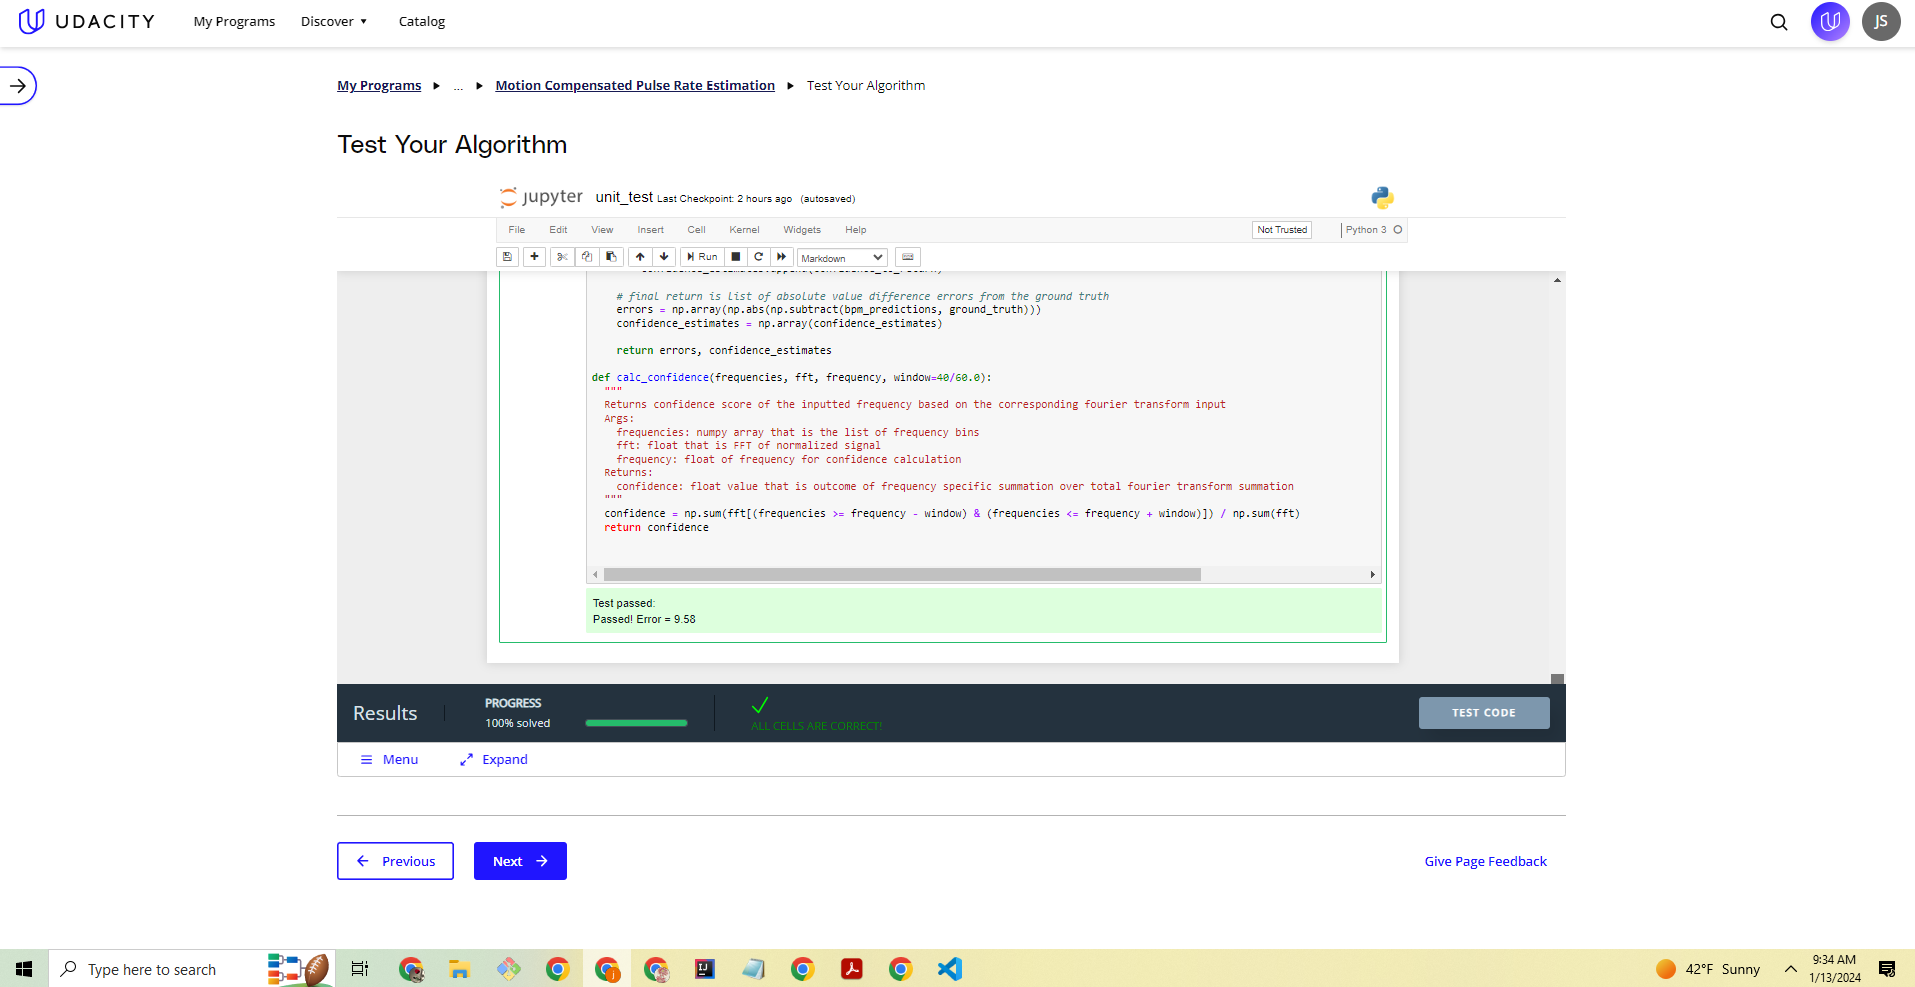
**Evaluation Metric: Train-test split**

**Relavent Error metric: MAE**

The algorithm met the project's requirement that the mean absolute error at the 90th percentile of estimates was less than 9.58  BPM on the test dataset in the test workspace/section(refer to screenshot above).
With the Evaluate command you can get the MAE of the algorithm which was right at  9.58 on the test set and 21.033671446513175
in training(cell below). Test error being lower than training error may hint to relatively good generalization capability of the algorithm.

To optimize the algorithm, each window had it's frequency selected based on  the maximum confidence score of each frequency.  

In [4]:
Evaluate()

21.033671446513175

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 